In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import sys
import pandas as pd
import os
sys.path.insert(0, '../seal_wrapper/')
from seal_wrapper import EA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'iris.data'), names=['sepal_length', 'sepal_width', 'petal_length',
                                                                  'petal_width', 'class'])

In [3]:
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.16, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.19, random_state=3)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(102, 4) (24, 4) (24, 4)
(102,) (24,) (24,)


In [6]:
X_scaler = StandardScaler()
y_encoder = LabelEncoder()
X_train = X_scaler.fit_transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)
y_encoder.fit(y_train)
y_train = to_categorical(y_encoder.transform(y_train))
y_val = to_categorical(y_encoder.transform(y_val))
y_test = to_categorical(y_encoder.transform(y_test))

In [7]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
def plot_predictions(pred, y, save_as=None):
    fig = plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title('Final layer values')
    ax.scatter(pred, y, alpha=0.2)
    ax.set_xlabel('encrypted')
    ax.set_ylabel('unencrypted')
    ax.plot(np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1))
    if save_as != None:
        plt.savefig(save_as)

In [9]:
def relu(z):
    return np.maximum(0, z)

In [22]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

## Evaluate models

In [11]:
weights = np.load('relu_weights.npy')
w1, b1, w2, b2 = weights

In [33]:
layer1_clear = X_test.dot(w1) + b1
layer1_relu_clear = relu(layer1_clear)
layer2_clear = layer1_relu_clear.dot(w2) + b2
pred_clear = softmax(layer2_clear)

In [34]:
pred = np.round(pred_clear.argmax(axis=1).reshape(-1,))
accuracy_score(pred, y_test.argmax(axis=1))

1.0

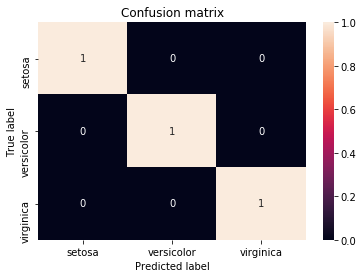

In [35]:
mat = confusion_matrix(pred_clear.argmax(axis=1), y_test.argmax(axis=1))
cm = mat / np.sum(mat, axis=1)
plot_confusion_matrix(cm, classes=['setosa', 'versicolor', 'virginica'])

In [36]:
X_test_enc = EA(X_test, to_encrypt=True)
w1_enc = EA(w1)
b1_enc = EA(b1.reshape(1, -1))
w2_enc = EA(w2)
b2_enc = EA(b2.reshape(1, -1))

In [37]:
layer1_enc = X_test_enc.dot(w1_enc) + b1_enc
layer1_relu_enc = layer1_enc.relu()
layer2_enc = layer1_relu_enc.dot(w2_enc) + b2_enc

In [38]:
pred_enc = softmax(layer2_enc.values())

In [39]:
pred_enc

array([[9.70404223e-01, 2.77277506e-02, 1.86802680e-03],
       [9.53633452e-01, 4.39317280e-02, 2.43481987e-03],
       [9.60838401e-01, 3.75187027e-02, 1.64289651e-03],
       [9.05505460e-01, 9.20998440e-02, 2.39469604e-03],
       [9.98585100e-01, 1.11506846e-03, 2.99831336e-04],
       [9.95944006e-05, 8.01814050e-03, 9.91882265e-01],
       [1.48616020e-01, 6.91798769e-01, 1.59585211e-01],
       [9.83663062e-01, 1.45819333e-02, 1.75500419e-03],
       [1.52689221e-02, 2.40958755e-01, 7.43772323e-01],
       [1.34313846e-01, 6.94388429e-01, 1.71297726e-01],
       [2.17275808e-01, 6.08435433e-01, 1.74288759e-01],
       [9.58892934e-01, 3.88069809e-02, 2.30008542e-03],
       [1.64049599e-01, 7.21781700e-01, 1.14168701e-01],
       [1.27196847e-01, 7.15890479e-01, 1.56912674e-01],
       [2.03438381e-03, 6.02390741e-02, 9.37726542e-01],
       [9.86011323e-01, 1.29243649e-02, 1.06431228e-03],
       [5.32836560e-02, 5.75751592e-01, 3.70964752e-01],
       [8.26635323e-04, 3.98966

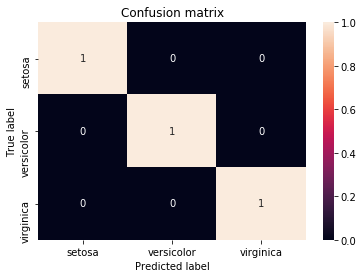

In [41]:
mat = confusion_matrix(pred_enc.argmax(axis=1), y_test.argmax(axis=1))
cm = mat / np.sum(mat, axis=1)
plot_confusion_matrix(cm, classes=['setosa', 'versicolor', 'virginica'])

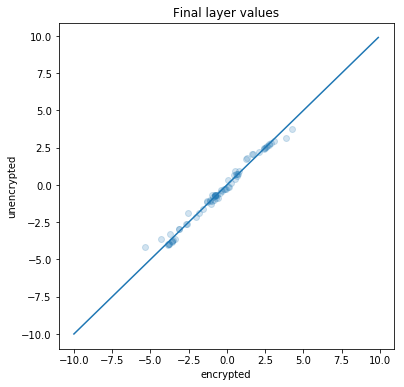

In [42]:
# final layer
plot_predictions(layer2_enc.values(), layer2_clear)